# decision tree
#### 1. 概要
        条件分岐のノードや閾値を人間が作るのは難しい。  
        それを客観的合理的に導いてモデルを作ろうというのが決定木。  
        どんな条件分岐が良いかは **「不純度」** をもとに決める。  
        つまり決定木では、不純度を損失関数としている。  
  
        （現在のノードの不純度）と、（分岐後のノードの不純度合計）を比較し、最も不純度が下がる分岐条件を採用していく。  
  
        回帰でも分類でも両方使えるらしいが、なんで？回帰ってどうやって使うん  
        **→あるノードに属するデータの分散を不純度の指標とするらしい。**  

**不純度の指標（一般）：**  
**分類問題ではジニ係数やエントロピー**  
**回帰問題では分散**  
  
  
#### 2. エントロピーについて
1. Information content $I(x)$
$$
        I(x) = - log_2\ p(x)
$$
$I(x)$：事象$x$の情報量。事象が起きたことの驚き具合を数値化した指標。考えた人天才。  
$p(x)$：事象$x$の起きる確率  

2. Entropy $H$（平均情報量）
$$
        H = \sum_i p(x_i)I(x_i) = \sum_i p(x_i) * -log_2 \ p(x_i)
$$
        情報量の平均値をとることで、事象のばらつき具合を表せる。
        大半は同じ事象しか起きない→エントロピー小
                例）砂漠の天気はほぼいつも晴れ
        観測するたびに事象がばらついている→エントロピー大
                例）東京の天気は晴だったり雨だったり曇りだったりする

  
あるノード$t$におけるエントロピーは添え字付きで$H_t$と表す。

3. Gini Index $G$：誤分類する確率を平均化した指標
あるノード$t$に於いて、クラス$x_i$が選ばれる確率を$p(x_i|t)$としたとき、  
ノード$t$おいて誤分類してしまう確率の期待値は
$$
        G(t) = \sum_i^K p(x_i|t)(1-p(x_i|t))
$$
$K$: クラス数


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

In [15]:
# データの読み込み
from sklearn.datasets import load_iris
iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris["label"] = iris.target
df_iris["label"] = df_iris["label"].map({0:iris.target_names[0], 1:iris.target_names[1], 2:iris.target_names[2]})


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\datasets\base.py:242: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target = np.empty((n_samples,), dtype=np.int)
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\datasets\base.py:246: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revie

In [19]:
display(df_iris.head())
display(df_iris.describe())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


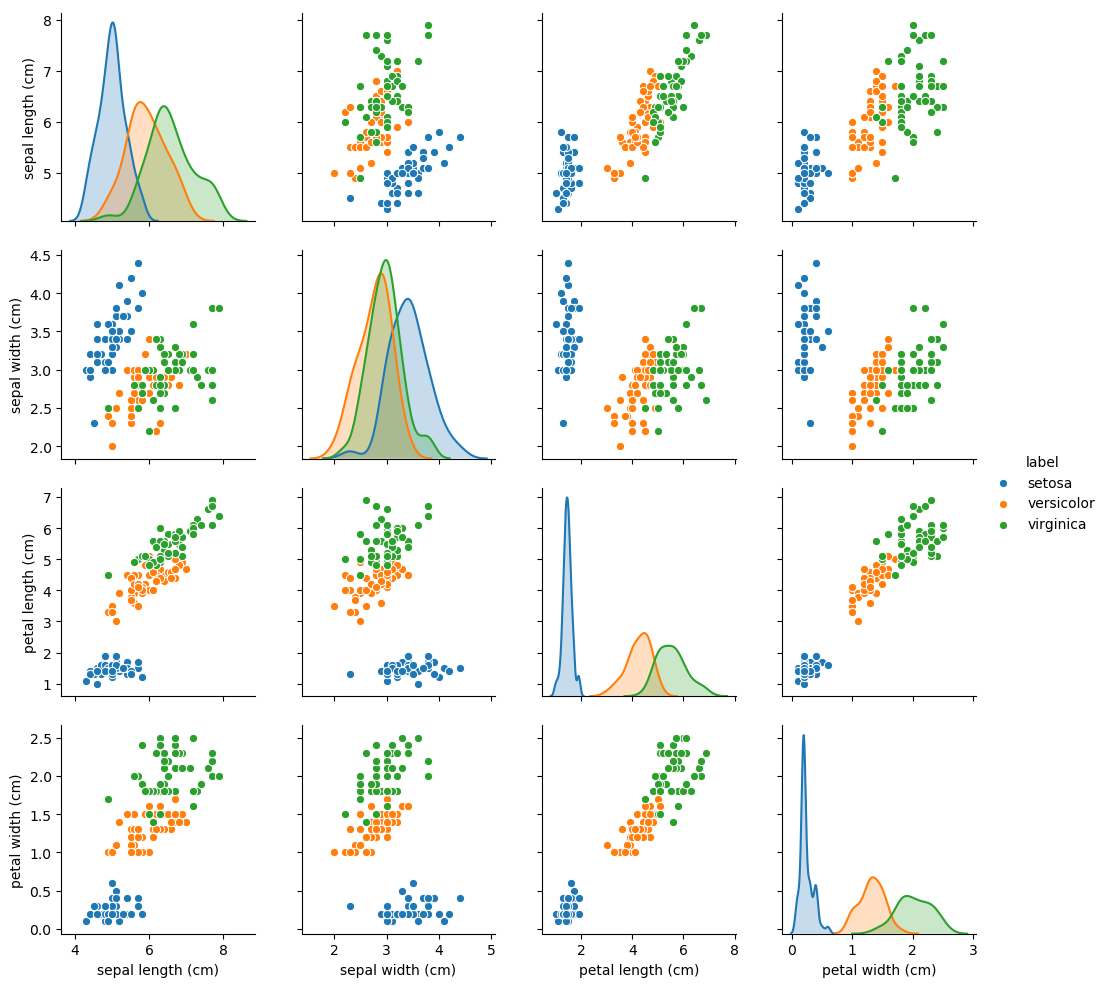

In [16]:
sns.pairplot(df_iris, hue="label")

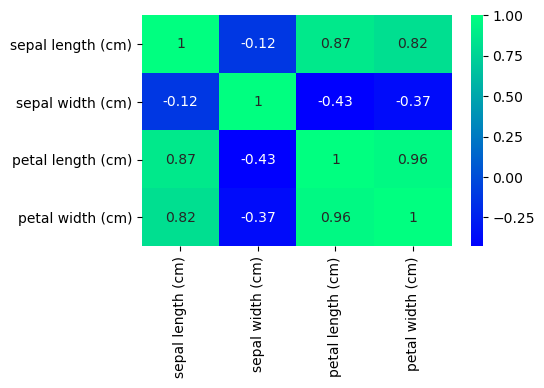

In [23]:
plt.figure(figsize=(5, 3))
sns.heatmap(df_iris.corr(), cmap='winter', annot=True)

まずは2変数まで切り落としてシンプルなデータで試してみる

,sepal width (cm),petal width (cm),label
0,3.5,0.2,setosa
1,3.0,0.2,setosa
2,3.2,0.2,setosa
3,3.1,0.2,setosa
4,3.6,0.2,setosa


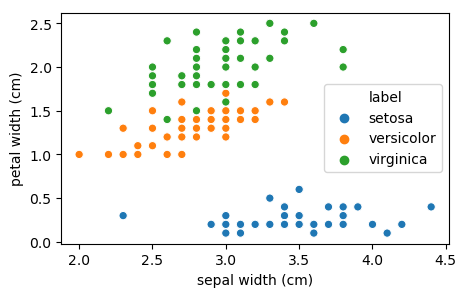

In [32]:
df_simple = df_iris.drop(['sepal length (cm)', 'petal length (cm)'], axis=1)
display(df_simple.head())
plt.figure(figsize=(5, 3))
sns.scatterplot(data=df_simple, x='sepal width (cm)', y='petal width (cm)', hue='label')

In [48]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

clf = DecisionTreeClassifier(criterion='gini', random_state=1234,
                             max_depth=None,
                             min_samples_leaf=3,
                             min_samples_split=3)

X = iris.data[:, [1, 3]]
y = iris.target

clf.fit(X, y)
clf.score(X, y), clf.feature_importances_


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)


(0.9666666666666667, array([0.03428065, 0.96571935]))

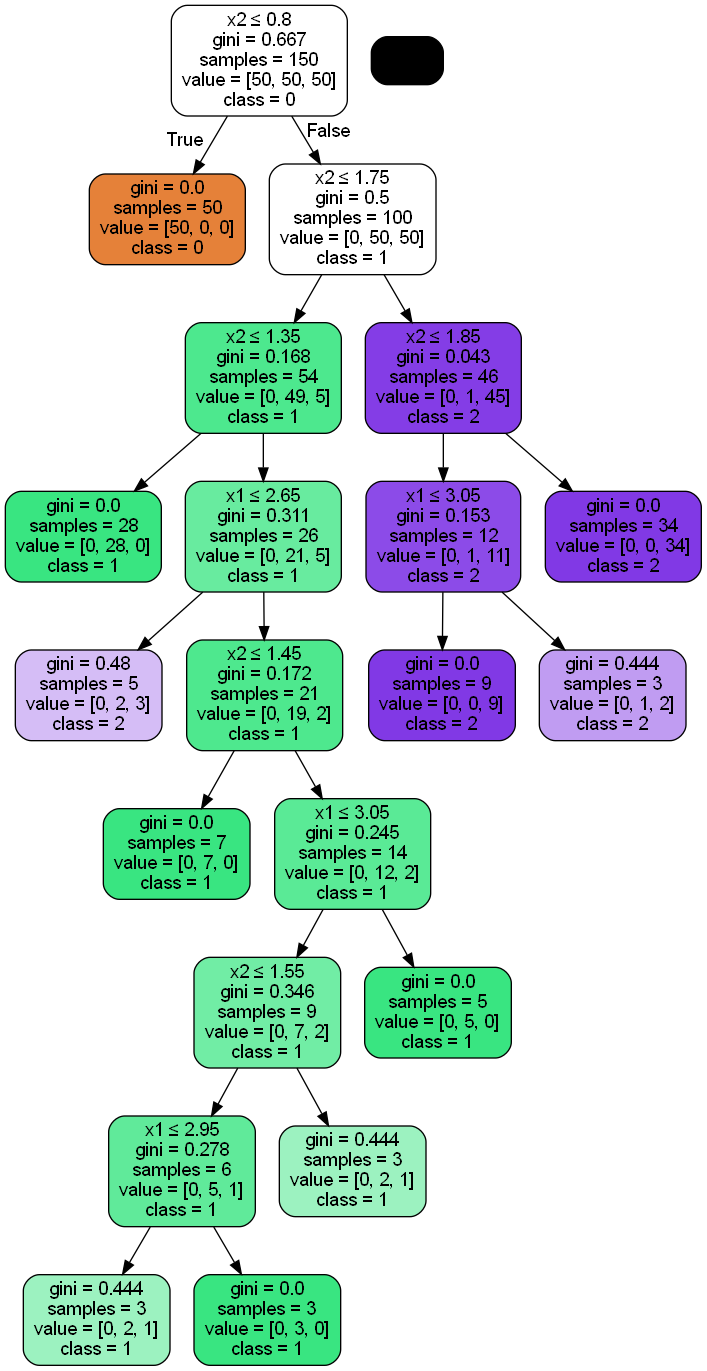

In [50]:
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf, out_file=dot_data,  
                     feature_names=["x1", "x2"],  
                     class_names=["0","1", "2"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

↑結構深いから汎化性能でなそう、確認する

In [68]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1234)
clf = DecisionTreeClassifier(criterion='gini', random_state=1234,
                             max_depth=None,
                             min_samples_leaf=3,
                             min_samples_split=3)

X = iris.data[:, [1, 3]]
y = iris.target

fold = 1
for train_idx, test_idx in kf.split(X, y):
    # print(f'train_idx = {train_idx}')
    # print(f'test_idx = {test_idx}')
    
    X_train, X_test = X[train_idx, :], X[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    # print(f'\n fold = {fold}')
    # print(f'X_train.shape = {X_train.shape}, X_test.shape = {X_test.shape}')
    # print(f'y_train.shape = {y_train.shape}, y_test.shape = {y_test.shape}')
    
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    f_importances = clf.feature_importances_
    
    print(f'score of fold{fold}: {score}')
    print(f'features of fold{fold}: {f_importances}')
    
    fold += 1


score of fold1: 1.0
features of fold1: [0.03243161 0.96756839]
score of fold2: 0.9
features of fold2: [0.02696462 0.97303538]
score of fold3: 0.9666666666666667
features of fold3: [0.0180633 0.9819367]
score of fold4: 0.9
features of fold4: [0.00523931 0.99476069]
score of fold5: 0.9666666666666667
features of fold5: [0.04267534 0.95732466]


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Depreca

全然汎化性能出た笑
全変数使ってやってみる

In [69]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1234)
clf = DecisionTreeClassifier(criterion='gini', random_state=1234,
                             max_depth=None,
                             min_samples_leaf=3,
                             min_samples_split=3)

# X = iris.data[:, [1, 3]]
X = iris.data
y = iris.target

fold = 1
for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx, :], X[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    f_importances = clf.feature_importances_
    
    print(f'score of fold{fold}: {score}')
    print(f'features of fold{fold}: {f_importances}')
    
    fold += 1


score of fold1: 1.0
features of fold1: [0.         0.         0.59731905 0.40268095]
score of fold2: 0.9666666666666667
features of fold2: [0.         0.         0.57907728 0.42092272]
score of fold3: 0.9666666666666667
features of fold3: [0.01056327 0.         0.57635096 0.41308577]
score of fold4: 0.9
features of fold4: [0.         0.         0.56889085 0.43110915]
score of fold5: 1.0
features of fold5: [0.         0.         0.57607895 0.42392105]


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Depreca

In [72]:
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


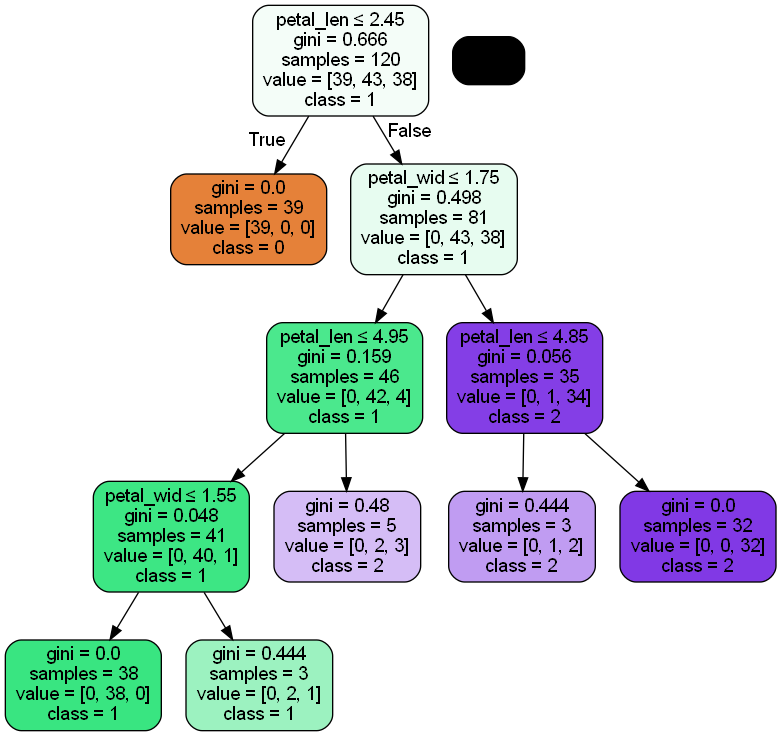

In [73]:
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf, out_file=dot_data,  
                     feature_names=["sepal_len", "sepal_wid", "petal_len", "petal_wid"],  
                     class_names=["0", "1", "2"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

# たくさん変数使うと浅いモデルで済むのかもしれない